## Exploratory Data Analysis

In this notebook, I will analyse and showcase the dataset based on the following criteria:

**1. Overall Hours Analysis:**
Examine the total hours quoted vs. the actual hours worked which includes overtime.

**2. Director Impact Analysis:**
Investigate whether the director in charge influences project hours or shows any trends.

**3. Correlation with House Prices:**
Explore whether there is a relationship between property value of the project, and the hours quoted / worked.

By the end of this analysis, I aim to uncover actionable insights that can help the firm improve its quoting accuracy, and explore what features might contribute towards a prediction model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.functions import postcode_anonymisation, director_anonymisation

#### Data Dictionary
| Variable          | Definition                                           |
|-------------------|------------------------------------------------------|
| Project No        | Project number on file                               |
| Project Address   | Project address                                      |
| Postcode          | Project postcode                                     |
| Director          | Director in charge                                   |
| Stage 1           | Hours quoted for Stage 1 (Preparation and Briefing)  |
| Stage 2           | Hours quoted for Stage 2 (Concept Design)            |
| Stage 3           | Hours quoted for Stage 3 (Spatial Coordination)      |
| Stage 4           | Hours quoted for Stage 4 (Technical Design)          |
| Stage 1 OT        | Overtime hours worked during Stage 1                 |
| Stage 2 OT        | Overtime hours worked during Stage 2                 |
| Stage 3 OT	    | Overtime hours worked during Stage 3                 |
| Stage 4 OT	    | Overtime hours worked during Stage 4                 |
| Current Est Value | Current estimated property value as of June 2024     |

In [2]:
df = pd.read_csv("data/Projects - Quote Data.csv", na_values="", keep_default_na=False)

In [3]:
# Omitting and anonymising certain columns to protect personal data
df.drop(["Project No", "Project Address"], axis=1, inplace=True)
postcode_anonymisation(df, "Postcode")
director_anonymisation(df, "Director")
df.head()

,Postcode,Director,Stage 1,Stage 2,Stage 3,Stage 4,Stage 1 OT,Stage 2 OT,Stage 3 OT,Stage 4 OT,Current Est Value
0,W4 ***,B,4,14,8,28,1.0,13.5,5.7,5.2,"£1,065,733"
1,SW17 ***,A,12,1,5,N/A,2.8,0.0,2.6,N/A,"£510,554"
2,SW16 ***,A,13,10,6,26,7.0,24.0,19,0,"£747,169"
3,SW11 ***,B,12,11,5,14,9.3,-2.0,12.17,18.9,"£1,520,156"
4,SW17 ***,A,12,14,7,35,-1.2,-4.7,-0.8,-1.89,"£658,430"


In [4]:
# Overview of information contained in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Postcode           50 non-null     object 
 1   Director           50 non-null     object 
 2   Stage 1            50 non-null     int64  
 3   Stage 2            50 non-null     int64  
 4   Stage 3            50 non-null     object 
 5   Stage 4            50 non-null     object 
 6   Stage 1 OT         49 non-null     float64
 7   Stage 2 OT         46 non-null     float64
 8   Stage 3 OT         45 non-null     object 
 9   Stage 4 OT         50 non-null     object 
 10  Current Est Value  50 non-null     object 
dtypes: float64(2), int64(2), object(7)
memory usage: 4.4+ KB


In [5]:
# Looking at missing values
df.isnull().sum()

Postcode             0
Director             0
Stage 1              0
Stage 2              0
Stage 3              0
Stage 4              0
Stage 1 OT           1
Stage 2 OT           4
Stage 3 OT           5
Stage 4 OT           0
Current Est Value    0
dtype: int64

**Note on Missing Value:**
It's worth mentioning that there are true missing values in this dataset, but there are also empty entries on purpose. There are "N/A" inputs representing "Not Applicable", these occur when a certain stage wasn't quoted for in a project. For example, a client could request a quote for Stages 1 and 2 only, then for Stage 3 and 4 it would be recorded as "Not Applicable".

In [6]:
# Counting values that are purposely not applicable values, as explained
df.apply(lambda x: (x == "N/A").sum())

Postcode             0
Director             0
Stage 1              0
Stage 2              0
Stage 3              2
Stage 4              6
Stage 1 OT           0
Stage 2 OT           0
Stage 3 OT           2
Stage 4 OT           7
Current Est Value    0
dtype: int64

In [7]:
# Looking at true missing values
df[df.isnull().any(axis=1)]

,Postcode,Director,Stage 1,Stage 2,Stage 3,Stage 4,Stage 1 OT,Stage 2 OT,Stage 3 OT,Stage 4 OT,Current Est Value
30,SW17 ***,A,12,15,6,26,-2.00,NaN,3,0,"£823,000"
32,SW16 ***,A,12,16,4,22,3.00,0.0,NaN,0,"£1,090,000"
34,SW17 ***,A,10,17,4,31,11.70,2.0,NaN,-10,"£1,003,232"
35,SW12 ***,A,8,11,3,22,NaN,-1.0,1.88,-10,"£688,090"
43,SE19 ***,B,11,11,5,16,8.00,27.0,NaN,-2,"£1,200,000"
45,SW16 ***,A,12,15,8,28,13.00,NaN,NaN,-6,"£567,845"
47,SW14 ***,A,15,21,7,35,6.50,NaN,NaN,-13.22,"£1,571,186"
49,SE15 ***,A,7,13,2,59,5.44,NaN,0,-12.5,"£1,306,986"


The true missing values in this dataset are predominantly found in the overtime columns. These missing data are largely attributed to human factors, specifically poor timesheet recording practices by the employees or directors.

From the list of observation with null values above, we can see that, except for one instance, all other observations with missing values are associated with Director A. This indicates a significant pattern where Director A's entries are more likely to have missing overtime records compared to those of Director B.

**This showcases that Director A has more projects with timesheet recording issues.**

### 1. Overall Hours Analysis

In [8]:
# omitting the "N/A" values in Stages columns
df.replace("N/A", np.nan, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Postcode           50 non-null     object 
 1   Director           50 non-null     object 
 2   Stage 1            50 non-null     int64  
 3   Stage 2            50 non-null     int64  
 4   Stage 3            48 non-null     object 
 5   Stage 4            44 non-null     object 
 6   Stage 1 OT         49 non-null     float64
 7   Stage 2 OT         46 non-null     float64
 8   Stage 3 OT         43 non-null     object 
 9   Stage 4 OT         43 non-null     object 
 10  Current Est Value  50 non-null     object 
dtypes: float64(2), int64(2), object(7)
memory usage: 4.4+ KB


In [9]:
stages_cols = df.columns[2:10].to_list()
df[stages_cols] = df[stages_cols].astype(np.float32)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Postcode           50 non-null     object 
 1   Director           50 non-null     object 
 2   Stage 1            50 non-null     float32
 3   Stage 2            50 non-null     float32
 4   Stage 3            48 non-null     float32
 5   Stage 4            44 non-null     float32
 6   Stage 1 OT         49 non-null     float32
 7   Stage 2 OT         46 non-null     float32
 8   Stage 3 OT         43 non-null     float32
 9   Stage 4 OT         43 non-null     float32
 10  Current Est Value  50 non-null     object 
dtypes: float32(8), object(3)
memory usage: 2.9+ KB


In [10]:
# I'd like to create a smaller dataframe looking at overall numbers based on the RIBA Stages
hours_quoted = df.iloc[:, 2:6].sum(axis=0)
hours_quoted

Stage 1     572.0
Stage 2     714.0
Stage 3     277.0
Stage 4    1349.0
dtype: float32

In [11]:
# Getting a column name for a new dataframe
stages = hours_quoted.index.tolist()
stages

['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']

In [12]:
hours_quoted = hours_quoted.tolist()
hours_quoted

[572.0, 714.0, 277.0, 1349.0]

In [13]:
hours_ot = df.iloc[:, 6:10].sum(skipna=True,axis=0).round(2).tolist()
hours_ot

[317.8399963378906, 359.0, 137.32000732421875, 122.83000183105469]

In [14]:
total_hours = []
for i in range(len(hours_ot)):
    sum = hours_quoted[i] + hours_ot[i]
    total_hours.append(sum)

total_hours

[889.8399963378906, 1073.0, 414.32000732421875, 1471.8300018310547]

In [15]:
df_hours = pd.DataFrame({
    "Stages": stages,
    "Quoted Hours": hours_quoted,
    "Overtime Hours": hours_ot,
    "Total Hours": total_hours
})

df_hours

,Stages,Quoted Hours,Overtime Hours,Total Hours
0,Stage 1,572.0,317.839996,889.839996
1,Stage 2,714.0,359.000000,1073.000000
2,Stage 3,277.0,137.320007,414.320007
3,Stage 4,1349.0,122.830002,1471.830002


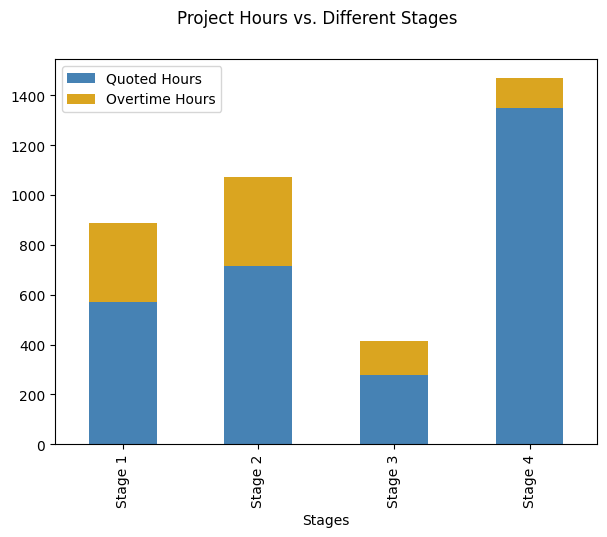

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

df_hours.plot(x="Stages", y=["Quoted Hours", "Overtime Hours"], kind="bar", stacked=True, color=["steelblue", "goldenrod"], ax=ax)
plt.suptitle("Project Hours vs. Different Stages")
plt.show()

In [17]:
# Looking at the amount of overtime occurs per stage
df_hours["Overtime %"] = round((df_hours["Overtime Hours"] / df_hours["Quoted Hours"]) * 100, 2)
df_hours

,Stages,Quoted Hours,Overtime Hours,Total Hours,Overtime %
0,Stage 1,572.0,317.839996,889.839996,55.57
1,Stage 2,714.0,359.000000,1073.000000,50.28
2,Stage 3,277.0,137.320007,414.320007,49.57
3,Stage 4,1349.0,122.830002,1471.830002,9.11


This shows that Stages 1 is the most under-quoted stage, 2 and 3 are majorly underquoted, being around 50% of the quoted hours, meaning the actual time spent is around 150% of what's quoted.

In [18]:
# Average hours of overtime by Stage
df_hours.groupby("Stages")["Overtime Hours"].sum()/df.shape[0]

Stages
Stage 1    6.3568
Stage 2    7.1800
Stage 3    2.7464
Stage 4    2.4566
Name: Overtime Hours, dtype: float64

Stage 2 has the highest overtime done by average at 7 hours. Stage 4 has the least, but still with 2.4 hours overtime done on average.

**This shows that all projects are generally under quoted, and the stage matters so it will be considered as a feature when building a model.**

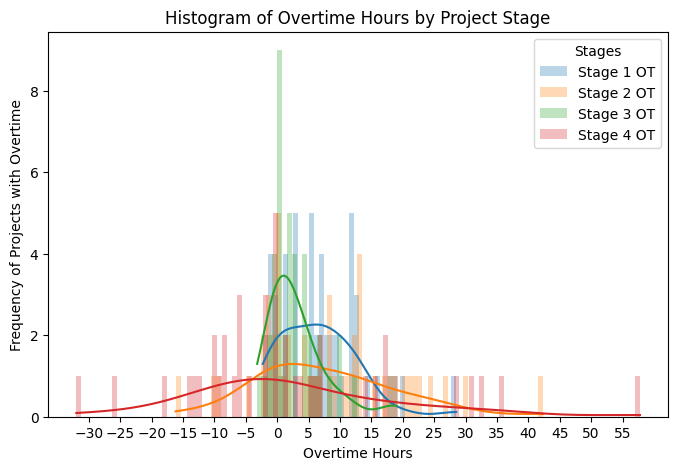

In [36]:
# Plotting a histogram to show the distribution of overtime hours per stage
ot_cols = ["Stage 1 OT", "Stage 2 OT", "Stage 3 OT", "Stage 4 OT"]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for col in ot_cols:
    sns.histplot(df[col], bins=15, kde=True, binwidth=0.8,
                 alpha=0.3, edgecolor=None, label=col, ax=ax)

# Adding a legend for different lines / bins
ax.legend(title="Stages")

# Setting the title and labels
ax.set_title("Histogram of Overtime Hours by Project Stage")
ax.set_xlabel("Overtime Hours")
ax.set_ylabel("Frequency of Projects with Overtime")

# Setting x axis tick frequency
ax.set_xticks(np.linspace(-30, 55, num=18)) 

plt.show()

**Insights of Histogram**

**Stage 3:** The kde line shows high peak around 2 hours, suggesting a fairly consistent overtime is required for most projects at stage 3. This could indicate a predictable workload with minor adjustments needed.

**Stage 1:** The distribution of overtime hours for Stage 1 is relatively spread out, with the majority of overtime hours occurring between 0 and 10 hours, and a gradual decline after 10 hours. The spread out overtime distribution suggests that while Stage 1 projects often require overtime, the extent varies widely, possibly due to varying project complexities or inaccuracies when judging how long the initial surveying and drafting might take.

**Stage 2:** Stage 2 overtime is a lot more spread out than 1 and 3, highlighting potential issues in this stage that necessitate substantial additional work, warranting further investigation into Stage 2 processes.

**Stage 4:** The wide range and high overtime hours, including extreme cases, emphasize the unpredictability and potential challenges in managing Stage 4 projects. This variability suggests a need for better forecasting and management strategies to handle unexpected workloads.

Overall, the histogram analysis reveals distinct patterns and potential areas for process improvement across different project stages, with Stage 4 standing out as particularly unpredictable and resource-intensive.

### 2. Director Impact Analysis

In [20]:
# Looking at the amount of projects for each director
df.value_counts("Director").sort_index(ascending=True)

Director
A    24
B    26
Name: count, dtype: int64

The dataset is fairly even, consisting of 24 projects with director A and 26 with director B.

In [21]:
# Creating 2 new columns to look at total hours
df["Total Quoted"] = df.iloc[:, 2:6].sum(axis=1, skipna=True)
df["Total OT"] = df.iloc[:, 6:10].sum(axis=1, skipna=True)
df["Total Hours"] = df.iloc[:, 11:].sum(axis=1, skipna=True)
df.head()

,Postcode,Director,Stage 1,Stage 2,Stage 3,Stage 4,Stage 1 OT,Stage 2 OT,Stage 3 OT,Stage 4 OT,Current Est Value,Total Quoted,Total OT,Total Hours
0,W4 ***,B,4.0,14.0,8.0,28.0,1.0,13.5,5.70,5.20,"£1,065,733",54.0,25.400002,79.400002
1,SW17 ***,A,12.0,1.0,5.0,NaN,2.8,0.0,2.60,NaN,"£510,554",18.0,5.400000,23.400000
2,SW16 ***,A,13.0,10.0,6.0,26.0,7.0,24.0,19.00,0.00,"£747,169",55.0,50.000000,105.000000
3,SW11 ***,B,12.0,11.0,5.0,14.0,9.3,-2.0,12.17,18.90,"£1,520,156",42.0,38.370003,80.370003
4,SW17 ***,A,12.0,14.0,7.0,35.0,-1.2,-4.7,-0.80,-1.89,"£658,430",68.0,-8.590000,59.410000


In [22]:
df.groupby("Director")["Total Quoted"].sum()

Director
A    1603.0
B    1309.0
Name: Total Quoted, dtype: float32

In [23]:
df.groupby("Director")["Total OT"].sum()

Director
A    382.459991
B    554.530029
Name: Total OT, dtype: float32

This shows that DireThis shows that Director A has quoted for more hours, and Director B has a lot more overtime hours done.

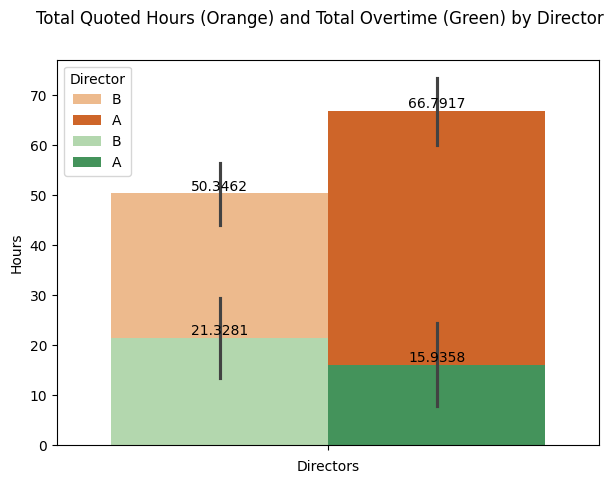

In [24]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

sns.barplot(df, y="Total Quoted", hue="Director", palette="Oranges", ax=ax)
sns.barplot(df, y="Total OT", hue="Director", palette="Greens", ax=ax)

for bin in ax.containers:
    ax.bar_label(bin)

plt.suptitle("Total Quoted Hours (Orange) and Total Overtime (Green) by Director")
plt.xlabel("Directors")
plt.ylabel("Hours")
plt.show()

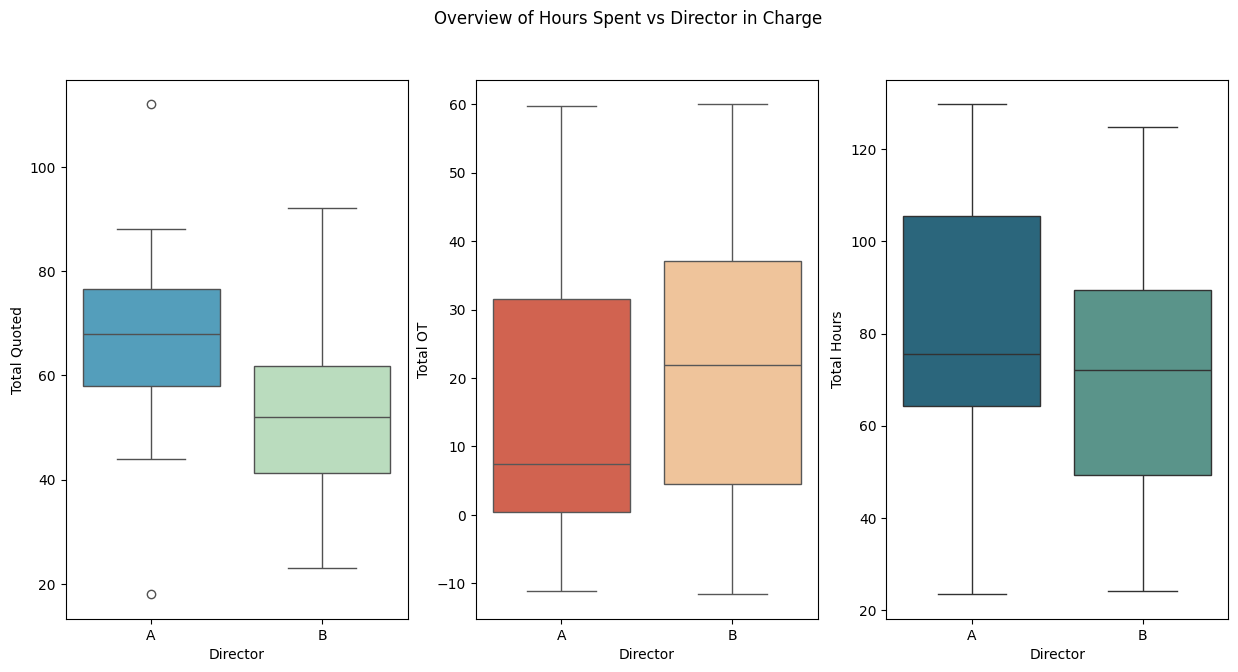

In [25]:
# Plotting the hours by the two directors
fig, ax = plt.subplots(1,3, figsize=(15,7))

sns.boxplot(data=df, x="Director", y="Total Quoted", order=["A", "B"],
            hue="Director", palette="GnBu", ax = ax[0])
sns.boxplot(data=df, x="Director", y="Total OT", order=["A", "B"],
            hue="Director", palette="OrRd", ax = ax[1])
sns.boxplot(data=df, x="Director", y="Total Hours", order=["A", "B"],
            hue="Director", palette="crest", ax = ax[2])

plt.suptitle("Overview of Hours Spent vs Director in Charge")
plt.show()

In the first plot, we observe that Director A generally quotes for more hours overall compared to Director B. A has an overall higher median and a much higher interquartile range. The boxplot shows that there are a couple of outliers at either end.

In the middle plot, more overtime on projects for Director B occurs. Although the difference between the interquartile range for the two directors is not as significant as the left plot, the median for total overtime hours worked for Director B's projects is notably higher than Director A's ones.

The last plot shows the total hours the projects ended up taking. It looks like the median is very close for A and B, as well as the extent of the whiskers. However, the interquartile range for Director A is higher despite other measures are fairly similar.

**Overall, it seems like Director A tends to quote for more hours, therefore the director should be considered as a feature for the model.**

The fact that Director A quotes for more hours could be because of they tend to take on bigger projects, or just that they are simply better than Director B at quoting more realistic hours. **However, it's important to note that significant overtime is still required for both directors.**

### 3. Correlation with the Project Property Value

This section aims to explore the relationship between the property value and the hours quoted/overworked for projects. Assess whether higher property values correlate with more hours quoted, under the hypothesis that homeowners with higher-value properties might invest more in their home therefore the project is bigger and more hours are required.

In [26]:
# Preprocessing the column
df["Current Est Value"] = df["Current Est Value"].replace({"£": "", ",": ""}, regex=True)
df["Current Est Value"] = pd.to_numeric(df["Current Est Value"])
df.head()

,Postcode,Director,Stage 1,Stage 2,Stage 3,Stage 4,Stage 1 OT,Stage 2 OT,Stage 3 OT,Stage 4 OT,Current Est Value,Total Quoted,Total OT,Total Hours
0,W4 ***,B,4.0,14.0,8.0,28.0,1.0,13.5,5.70,5.20,1065733,54.0,25.400002,79.400002
1,SW17 ***,A,12.0,1.0,5.0,NaN,2.8,0.0,2.60,NaN,510554,18.0,5.400000,23.400000
2,SW16 ***,A,13.0,10.0,6.0,26.0,7.0,24.0,19.00,0.00,747169,55.0,50.000000,105.000000
3,SW11 ***,B,12.0,11.0,5.0,14.0,9.3,-2.0,12.17,18.90,1520156,42.0,38.370003,80.370003
4,SW17 ***,A,12.0,14.0,7.0,35.0,-1.2,-4.7,-0.80,-1.89,658430,68.0,-8.590000,59.410000


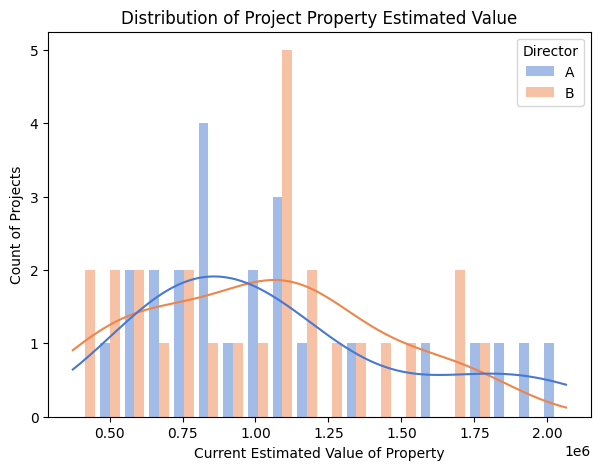

In [40]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
sns.histplot(data=df, x="Current Est Value", bins=20, hue="Director", kde=True, multiple="dodge",
            shrink=.8, palette="muted", ec="None", ax=ax, hue_order=["A", "B"])

ax.set_title("Distribution of Project Property Estimated Value")
ax.set_xlabel("Current Estimated Value of Property")
ax.set_ylabel("Count of Projects")
plt.show()

In [28]:
print("Average value of all projects:")
print(df.groupby("Director")["Current Est Value"].mean())

print("Median value of all projects:")
print(df.groupby("Director")["Current Est Value"].median())

Average value of all projects:
Director
A    1.072060e+06
B    1.015438e+06
Name: Current Est Value, dtype: float64
Median value of all projects:
Director
A     976616.0
B    1052142.5
Name: Current Est Value, dtype: float64


Previously I speculated on the reasons why Director A quotes for more hours for their projects. I suggested that it could be because they take on bigger / more valued projects, as then the clients for such projects are likely to be willing to spend more money on their renovation project.

Looking at the histogram and the average value of all projects, A and B have quite a similar range, with A's amount of higher end projects to be slightly higher. However, B's project property values has a higher median, and the kde curve looks like the distribution is slightly shifted towards the right (the more expensive end). Therefore A and B's project property values are actually not too dissimilar, and the difference isn't significant enough.

**This then indicates and confirms that Director B is likely to under-quote more.** 

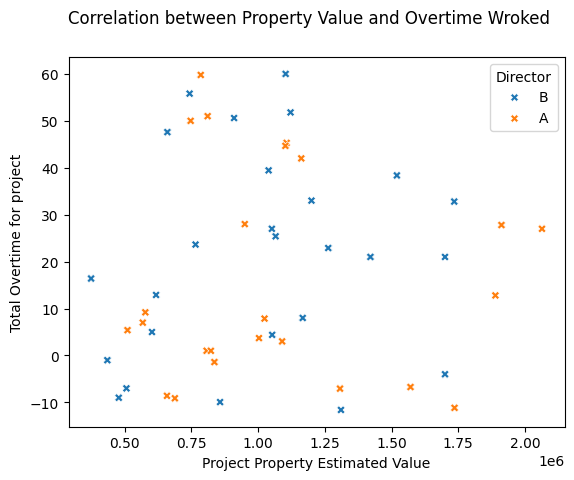

In [42]:
# Exploring to see if there's a correlation between the house value and the amount of overtime worked
sns.scatterplot(df, x="Current Est Value", y="Total OT", hue="Director", marker="X")
plt.xlabel("Project Property Estimated Value")
plt.ylabel("Total Overtime for project")
plt.suptitle("Correlation between Property Value and Overtime Wroked")
plt.show()

Previously, I assumed that there might be some correlation between property value and overtime worked, i.e. the bigger projects (more expensive properties) might end up having more work needed than initially planned for, therefore requiring more hours and result overtime.

To my surprise, the scatter plot above does not really show a correlation, as the observations almost look like they're distributed at random.

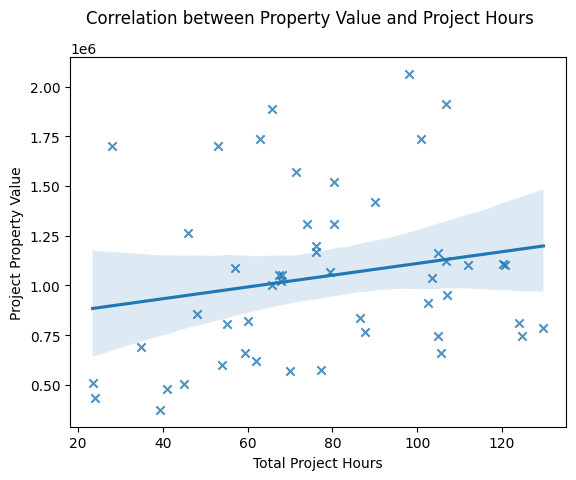

In [43]:
# Exploring to see if there's a correlation between the hours quoted by Directors and the property value
sns.regplot(df, x="Total Hours", y="Current Est Value", marker="x")
plt.xlabel("Total Project Hours")
plt.ylabel("Project Property Value")
plt.suptitle("Correlation between Property Value and Project Hours")
plt.show()

It looks like there is a positive correlation between the project property value and the total hours required, as initially speculated. Therefore the project property value should be used as a feature.

<Figure size 640x480 with 0 Axes>

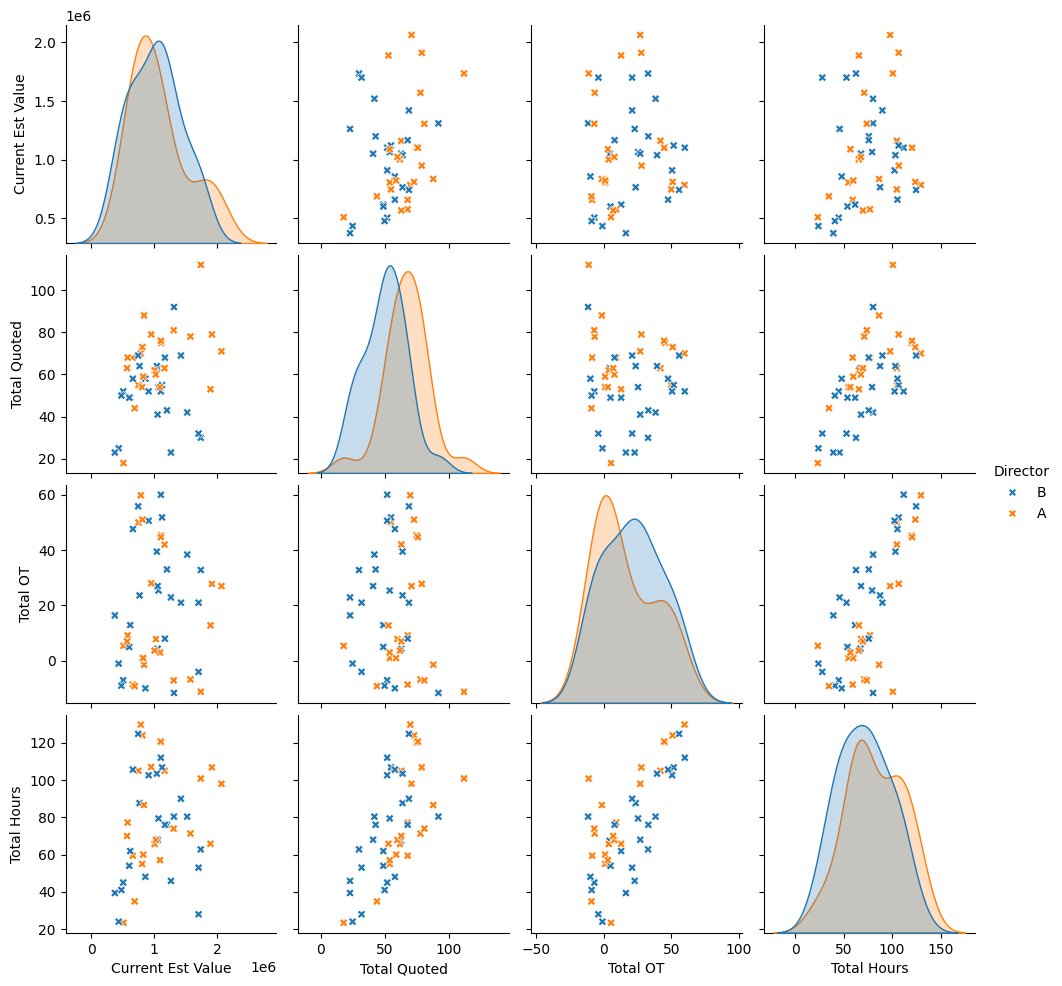

In [31]:
plt.figure()
sns.pairplot(df, vars=df.columns[10:].tolist(), markers="X", hue="Director")
plt.show()

The pairplot shows that the property value might have a slight positive correlation with hours quoted / total hours. But the hours quoted have a clear positive correlation with total hours, therefore the initial input of hours quoted is still relevant.

## Summary of Findings

1. The RIBA Stage will play a factor, as some stages are more severely under-quoted.

2. Director B is likely to under-quote more hours.

3. Director A's projects has issues with missing recordings in the dataset.

4. House price does not seem to have a correlation with overtime, but might have a positive correlation with overall time spent on a project.

Therefore as a summary, my intended features (X) and target (y) variables for the model are as such:

|**X:**
|-
|director
|property value of project
|stage number
|intended quoted hours for this stage
|**y:**
|expected total hours for that stage (i.e. adjusted quote suggestion)